# 치킨의 최고가 최저가 확인
빵형의 개발도상국 Korea-Chicken-Database 예제

원본 링크 - https://github.com/kairess/Korea-Chicken-Database

카카오 API - Keyword Search URL을 이용함

## Keyword Search URL 사용법 연습

In [1]:
import requests
from tqdm import tqdm
import time

In [2]:
app_key = 'KakaoAK ' + '__API_키_입력__' # REST API key

url = 'https://dapi.kakao.com/v2/local/search/keyword.json' # keyword search url 

params = {
    'query': '치킨', # 키워드
    'category_group_code': 'FD6', # 카테고리 코드 (음식점)
    'page': 45 # 45번째 페이지에서 받아옴
}

headers = {
    'Authorization': app_key
}

res = requests.get(url, params=params, headers=headers).json() # 데이터를 불러올 때 requests.get을 통해 json 형태로 받음

print(res.keys()) # output -> [documet, meta]

dict_keys(['documents', 'meta'])


In [3]:
res['documents'] # 안에 가격 데이터는 없다!

[{'address_name': '대구 중구 삼덕동1가 62-1',
  'category_group_code': 'FD6',
  'category_group_name': '음식점',
  'category_name': '음식점 > 치킨',
  'distance': '',
  'id': '1767432954',
  'phone': '053-252-5575',
  'place_name': '삼덕통닭 동성로점',
  'place_url': 'http://place.map.kakao.com/1767432954',
  'road_address_name': '대구 중구 동성로5길 89',
  'x': '128.59942495762826',
  'y': '35.867132464640896'},
 {'address_name': '서울 관악구 봉천동 1679-6',
  'category_group_code': 'FD6',
  'category_group_name': '음식점',
  'category_name': '음식점 > 치킨',
  'distance': '',
  'id': '25592312',
  'phone': '02-872-0029',
  'place_name': '동네아저씨치킨',
  'place_url': 'http://place.map.kakao.com/25592312',
  'road_address_name': '서울 관악구 행운2길 16',
  'x': '126.959882391254',
  'y': '37.4792256509999'},
 {'address_name': '부산 금정구 장전동 146-2',
  'category_group_code': 'FD6',
  'category_group_name': '음식점',
  'category_name': '음식점 > 치킨',
  'distance': '',
  'id': '8860320',
  'phone': '051-514-3885',
  'place_name': '뉴숯불통닭 본점',
  'place_url': 

In [4]:
res['meta']

{'is_end': True,
 'pageable_count': 45,
 'same_name': {'keyword': '치킨', 'region': [], 'selected_region': ''},
 'total_count': 56661}

In [5]:
params = {
    'query': '치킨',
    'page': 46 # 45페이지를 넘어가면 에러를 출력하게 된다!
}

res = requests.get(url, params=params, headers=headers).json()

print(res)

{'errorType': 'InvalidArgument', 'message': 'page is more than max'}


문제 1 : 데이터에 치킨 가격의 정보는 들어있지 않다.

-> 해결 : 세부 화면에 들어가 가격정보를 긁어와(크롤링) DB 생성

문제 2 : 최대 45페이지의 식당 정보밖에 가져올 수 없음

-> 구역을 쪼개어(분할 검색) 데이터를 부분적으로 저장하는 형태로 진행

## 데이터 크롤링

In [8]:
from tinydb import TinyDB, Query

db = TinyDB('db.json')

In [ ]:
start_x = 126 # 126.0 - 130.0
start_y = 33 # 33.0 - 39.0

dx = 0.25 # x좌표 이동 범위
dy = 0.25 # y좌표 이동 범위

for i in tqdm(range(18)): # x축 18번 이동
    for j in range(26): # y축 26번 이동
        x = start_x + dx * i
        y = start_y + dy * j
        print(x, y)

        for page in range(1, 46): # 1~45페이지까지
            params = {
                'query': '치킨',
                'page': page,
                'rect': f'{x},{y},{x + dx},{y + dy}' # 위경도
            }

            res = requests.get(url, params=params, headers=headers).json()
            
            if len(res['documents']) == 0:
                break

            for doc in res['documents']: # 크롤링
                place_name = doc['place_name']

                detail_url = f'https://place.map.kakao.com/main/v/{doc["id"]}' # id가 들어가면 json 형태로 넘어옴 (카카오에서 이상하게 만든듯)

                data = requests.get(detail_url, headers=headers).json()

                if 'menuInfo' not in data:
                    continue

                menu_list = data['menuInfo']['menuList']

                for menu_item in menu_list:
                    price = 0
                    if 'price' in menu_item:
                        price = int(menu_item['price'].replace(',', '')) # 가격을 int형변환

                    db.insert({ # db에 데이터 저장
                        'place_name': place_name,
                        'menu': menu_item['menu'],
                        'price': price
                    })
                
                time.sleep(5) # ip 차단을 위해 5초 대기

            if res['meta']['is_end']:
                break

## DB 활용

In [9]:
db # db에는 56202개의 데이터를 포함하고 있다.

<TinyDB tables=['_default'], tables_count=1, default_table_documents_count=56202, all_tables_documents_count=['_default=56202']>

In [10]:
db.search(Query().price > 35000) # 35000원이 초과하는 데이터를 탐색

[{'place_name': '돌담너머바다 판포점', 'menu': '돔베 스테이크', 'price': 39000},
 {'place_name': '마담나탈리소셜클럽', 'menu': '글렌피딕 15Y', 'price': 250000},
 {'place_name': '인판포', 'menu': '바베큐 플레이터', 'price': 60000},
 {'place_name': '인판포', 'menu': '마라소라새우', 'price': 40000},
 {'place_name': '제마닭', 'menu': '닭도리탕(대)', 'price': 36000},
 {'place_name': '제마닭', 'menu': '꽃도리탕(중)', 'price': 38000},
 {'place_name': '제마닭', 'menu': '꽃도리탕(대)', 'price': 48000},
 {'place_name': '먹고정', 'menu': '백돼지한근반', 'price': 63000},
 {'place_name': '먹고정', 'menu': '백돼지한근', 'price': 42000},
 {'place_name': '먹고정', 'menu': '흑돼지한근반', 'price': 80000},
 {'place_name': '먹고정', 'menu': '흑돼지한근', 'price': 54000},
 {'place_name': '모루쿠다', 'menu': '모루쿠다 육합', 'price': 40000},
 {'place_name': '원조장수통닭', 'menu': '토종닭', 'price': 60000},
 {'place_name': '원조장수통닭', 'menu': '오리주물럭', 'price': 60000},
 {'place_name': '진솔통닭', 'menu': '토종닭(1마리)', 'price': 60000},
 {'place_name': '진솔통닭', 'menu': '오리(1마리)', 'price': 60000},
 {'place_name': '오름지미정원', 'menu': '찹스테이크 (3

In [11]:
db.search((Query().price > 35000) & (Query().menu.search('치'))) # 35000원이 초과 & 메뉴에 치가 포함된 데이터 탐색

[{'place_name': '화덕에꾸운닭 전남담양점', 'menu': '랍스터 치킨', 'price': 38000},
 {'place_name': '아웃닭 신촌역점', 'menu': '오리지날 레드핀 양념치킨', 'price': 187000},
 {'place_name': '누구나홀딱반한닭 홍대점', 'menu': '바사칸치빵파티', 'price': 36900},
 {'place_name': '크치치킨 경희대점', 'menu': '치킨세트D', 'price': 37000},
 {'place_name': '누구나홀딱반한닭 선릉점', 'menu': '바사칸치빵파티', 'price': 38900},
 {'place_name': '화덕에꾸운닭 강원홍천점', 'menu': '랍스터 치킨', 'price': 38000},
 {'place_name': '화덕에꾸운닭 창원진동점', 'menu': '랍스터 치킨', 'price': 38000},
 {'place_name': '앗싸마늘닭 본점', 'menu': '앗싸 스페셜 두마리 치찜세트', 'price': 37900}]

In [12]:
chickens = db.search(Query().menu.search('치'))

prices = []

for chicken in chickens:
    prices.append(chicken['price'])
    
avg_price = sum(prices) / len(prices)

print('치킨 %d개의 평균 가격은 %.2f원 입니다' % (len(chickens), avg_price))

치킨 22670개의 평균 가격은 17762.21원 입니다


### Matplot.lib를 활용하여 그래프로 표기

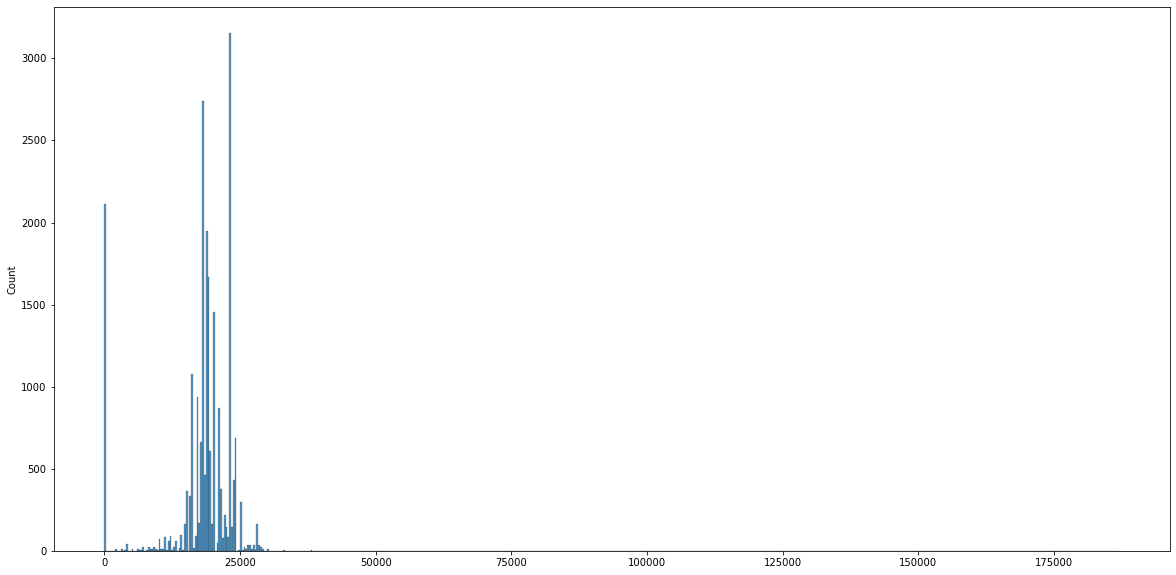

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(x=prices, ax=ax)